In [1]:
import qiskit

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')

#append to system path so qiskit and Qconfig can be found from home directory
sys.path.append('../qiskit-sdk-py/')

# Import the QuantumProgram and configuration
#from qiskit import QuantumProgram
#import Qconfig

#other useful packages
import math

ImportError: cannot import name 'QuantumProgram' from 'qiskit' (unknown location)

In [27]:
#Super secret message
mes = input('Enter your super secret message: ')

#initial size of key
n = len(mes)*3

#break up message into smaller parts if length > 10
nlist = []
for i in range(int(n/10)):
    nlist.append(10)
if n%10 != 0:
    nlist.append(n%10)

print('Initial key length: ',n)

Enter your super secret message: ghuyhuyhuyhuygytghyhyihh
Initial key length:  72


In [28]:
# Make random strings of length string_length

def randomStringGen(string_length):
    #output variables used to access quantum computer results at the end of the function
    output_list = []
    output = ''
    
    #start up your quantum program
    qp = QuantumProgram()
    backend = 'local_qasm_simulator'  
    circuits = ['rs']
    
    #run circuit in batches of 10 qubits for fastest results. The results
    #from each run will be appended and then clipped down to the right n size.
    n = string_length
    temp_n = 10
    temp_output = ''
    for i in range(math.ceil(n/temp_n)):
        #initialize quantum registers for circuit
        q = qp.create_quantum_register('q',temp_n)
        c = qp.create_classical_register('c',temp_n)
        rs = qp.create_circuit('rs',[q],[c])
            
        #create temp_n number of qubits all in superpositions
        for i in range(temp_n):
            rs.h(q[i]) #the .h gate is the Hadamard gate that makes superpositions
            rs.measure(q[i],c[i])

        #execute circuit and extract 0s and 1s from key
        result = qp.execute(circuits, backend, shots=1)
        counts = result.get_counts('rs')
        result_key = list(result.get_counts('rs').keys())
        temp_output = result_key[0]
        output += temp_output
        
    #return output clipped to size of desired string length
    return output[:n]

In [29]:
key = randomStringGen(n)
print('Initial key: ',key)


Initial key:  110001110001110111011110111110010000101001000110000100000111111000001011


In [30]:
#generate random rotation strings for Alice and Bob
Alice_rotate = randomStringGen(n)
Bob_rotate = randomStringGen(n)
print("Alice's rotation string:",Alice_rotate)
print("Bob's rotation string:  ",Bob_rotate)

#start up your quantum program
backend = 'local_qasm_simulator'  
shots = 1
circuits = ['send_over']
Bob_result = ''

for ind,l in enumerate(nlist):
    #define temp variables used in breaking up quantum program if message length > 10
    if l < 10:
        key_temp = key[10*ind:10*ind+l]
        Ar_temp = Alice_rotate[10*ind:10*ind+l]
        Br_temp = Bob_rotate[10*ind:10*ind+l]
    else:
        key_temp = key[l*ind:l*(ind+1)]
        Ar_temp = Alice_rotate[l*ind:l*(ind+1)]
        Br_temp = Bob_rotate[l*ind:l*(ind+1)]
    
    #start up the rest of your quantum program
    qp2 = QuantumProgram()
    q = qp2.create_quantum_register('q',l)
    c = qp2.create_classical_register('c',l)
    send_over = qp2.create_circuit('send_over',[q],[c])
    
    #prepare qubits based on key; add Hadamard gates based on Alice's and Bob's
    #rotation strings
    for i,j,k,n in zip(key_temp,Ar_temp,Br_temp,range(0,len(key_temp))):
        i = int(i)
        j = int(j)
        k = int(k)
        if i > 0:
            send_over.x(q[n])
        #Look at Alice's rotation string
        if j > 0:
            send_over.h(q[n])
        #Look at Bob's rotation string
        if k > 0:
            send_over.h(q[n])
        send_over.measure(q[n],c[n])

    #execute quantum circuit
    result_so = qp2.execute(circuits, backend, shots=shots)
    counts_so = result_so.get_counts('send_over')
    result_key_so = list(result_so.get_counts('send_over').keys())
    Bob_result += result_key_so[0][::-1]
    
print("Bob's results: ", Bob_result)

Alice's rotation string: 010100001001111101111110011110000110111111100001011111100010111101100011
Bob's rotation string:   010110110101000101101001101000011110001011001110000111110100110100101100
Bob's results:  110001100101100111001011111110011000101101101100000100000011110001000100


In [31]:
def makeKey(rotation1,rotation2,results):
    key = ''
    count = 0
    for i,j in zip(rotation1,rotation2):
        if i == j:
            key += results[count]
        count += 1
    return key
  
Akey = makeKey(Bob_rotate,Alice_rotate,key)
Bkey = makeKey(Bob_rotate,Alice_rotate,Bob_result)

print("Alice's key:",Akey)
print("Bob's key:  ",Bkey)

Alice's key: 11001011110110000010100100001110000
Bob's key:   11001011110110000010100100001110000


In [32]:
#make key same length has message
shortened_Akey = Akey[:len(mes)]
encoded_m=''

#encrypt message mes using encryption key final_key
for m,k in zip(mes,shortened_Akey):
    encoded_c = chr(ord(m) + 2*ord(k) % 256)
    encoded_m += encoded_c
print('encoded message:  ',encoded_m)

#make key same length has message
shortened_Bkey = Bkey[:len(mes)]

#decrypt message mes using encryption key final_key
result = ''
for m,k in zip(encoded_m,shortened_Bkey):
    encoded_c = chr(ord(m) - 2*ord(k) % 256)
    result += encoded_c
print('recovered message:',result)

encoded message:   ÉÊÕÙÊÕÛÊ×ÛÈ×ÛÇÙÔÇÈÛÈÛÉÈÊ
recovered message: ghuyhuyhuyhuygytghyhyihh


In [33]:

#start up your quantum program
backend = 'local_qasm_simulator'  
shots = 1
circuits = ['Eve']

Eve_result = ''
for ind,l in enumerate(nlist):
    #define temp variables used in breaking up quantum program if message length > 10
    if l < 10:
        key_temp = key[10*ind:10*ind+l]
        Ar_temp = Alice_rotate[10*ind:10*ind+l]
    else:
        key_temp = key[l*ind:l*(ind+1)]
        Ar_temp = Alice_rotate[l*ind:l*(ind+1)]
    
    #start up the rest of your quantum program
    qp3 = QuantumProgram()
    q = qp3.create_quantum_register('q',l)
    c = qp3.create_classical_register('c',l)
    Eve = qp3.create_circuit('Eve',[q],[c])
    
    #prepare qubits based on key; add Hadamard gates based on Alice's and Bob's
    #rotation strings
    for i,j,n in zip(key_temp,Ar_temp,range(0,len(key_temp))):
        i = int(i)
        j = int(j)
        if i > 0:
            Eve.x(q[n])
        if j > 0:
            Eve.h(q[n])
        Eve.measure(q[n],c[n])
    
    #execute
    result_eve = qp3.execute(circuits, backend, shots=shots)
    counts_eve = result_eve.get_counts('Eve')
    result_key_eve = list(result_eve.get_counts('Eve').keys())
    Eve_result += result_key_eve[0][::-1]

print("Eve's results: ", Eve_result)

Eve's results:  110001110001100110000100110010010110000011100111011011100111010001001000


In [34]:

#start up your quantum program
backend = 'local_qasm_simulator'  
shots = 1
circuits = ['Eve2']

Bob_badresult = ''
for ind,l in enumerate(nlist):
    #define temp variables used in breaking up quantum program if message length > 10
    if l < 10:
        key_temp = key[10*ind:10*ind+l]
        Eve_temp = Eve_result[10*ind:10*ind+l]
        Br_temp = Bob_rotate[10*ind:10*ind+l]
    else:
        key_temp = key[l*ind:l*(ind+1)]
        Eve_temp = Eve_result[l*ind:l*(ind+1)]
        Br_temp = Bob_rotate[l*ind:l*(ind+1)]
    
    #start up the rest of your quantum program
    qp4 = QuantumProgram()
    q = qp4.create_quantum_register('q',l)
    c = qp4.create_classical_register('c',l)
    Eve2 = qp4.create_circuit('Eve2',[q],[c])
    
    #prepare qubits
    for i,j,n in zip(Eve_temp,Br_temp,range(0,len(key_temp))):
        i = int(i)
        j = int(j)
        if i > 0:
            Eve2.x(q[n])
        if j > 0:
            Eve2.h(q[n])
        Eve2.measure(q[n],c[n])
    
    #execute
    result_eve = qp4.execute(circuits, backend, shots=shots)
    counts_eve = result_eve.get_counts('Eve2')
    result_key_eve = list(result_eve.get_counts('Eve2').keys())
    Bob_badresult += result_key_eve[0][::-1]
    
print("Bob's previous results (w/o Eve):",Bob_result)
print("Bob's results from Eve:\t\t ",Bob_badresult)

Bob's previous results (w/o Eve): 110001100101100111001011111110011000101101101100000100000011110001000100
Bob's results from Eve:		  110111110100100011100100010010000100001011101001011101100011000001101100


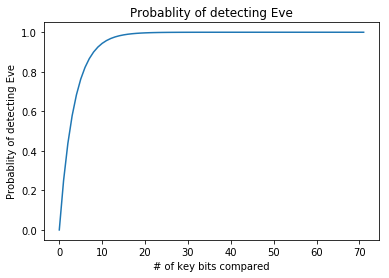

In [35]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0., len(Bob_result))
y = 1-(3/4)**x
plt.plot(y)
plt.title('Probablity of detecting Eve')
plt.xlabel('# of key bits compared')
plt.ylabel('Probablity of detecting Eve')
plt.show()